In [185]:
#@authors: Isabel Burgos, Francesca Drummer, Lennart Geertjes, Madelief Rennspies, Ellen Schrader
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
#sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5,3)})
# import distributions
from scipy.stats import *
import numpy as np
import functools 

In [186]:
#This function returns the feature of the tile flipped and the object below it. 
#Theta = vector of category probabilities of the features
#Psi = vector of category probabilities of the objects given the features (deterministic)
#The number of objects n and features k is included implicitly in the size of the corresponding arrays
def environment(theta_1, theta_2,psi):
    #Draw feature from a categorical distribution
    feature = np.array(multinomial.rvs(p = theta_1, n = 1))
    location = np.array(multinomial.rvs(p = theta_2, n = 1))
    
    #Get index of location and feature (starting at 0)
    idx_feature = list(feature).index(1)
    idx_location = list(location).index(1)
    
    #Draw the object from a categorical distribution given the feature
    obj     = multinomial.rvs(p = psi[idx_feature, idx_location].flatten(), n = 1)
    
    #Get index of object
    idx_object  = list(obj).index(1)
    
    return idx_feature, idx_object, idx_location

In [187]:
#Model of the agent. The function returns the predicted probability distribution over the objects given the features
#and the index of the predicted object
#Note: we might not need the predicted object and the index of the object itself but it is still included as it might
#be useful for some of us
def agent(psi, alpha, idx_feature, idx_location):
    psi[idx_feature, idx_location, :] = dirichlet.rvs(alpha[idx_feature, idx_location,:])
    obj = multinomial.rvs(p=psi[idx_feature, idx_location, :], n=1)
    idx_object  = list(obj).index(1)
    return psi, idx_object

In [188]:
#The agent learns the probability distribution of the objects given a specific feature
#n_iter = the number of iterations in this observations the agent sees
#n_objects = the number of objects
#n_features = the number of features and thus also of tiles

def trial(n_iter, n_objects, n_features, n_locations, psi_env):
    ####Initial values###
    alpha = np.full((n_features, n_locations, n_objects), 1) ## added n_location as 2nd parameter such that matrix looks the same as for psi_env
    #pre_errors = [[[]]*(n_locations)]*(n_features)
    pre_errors = [[[] for _ in range(n_locations)] for _ in range(n_features)]  # made list comprehensions such that the list object is new each time
    psi_agent = np.full((n_features, n_locations, n_objects), 1/n_objects) ## added n_location as 2nd parameter such that matrix looks the same as for psi_env
    #If you want specific features to occur more often change e.g., to theta = [0.8,0.1,0.1]
    theta_1 = np.repeat(1/n_features,n_features)
    theta_2 = np.repeat(1/n_locations,n_locations)
    
    ###Updating the agent's generative model###
    for i in range(0,n_iter):
        
        #Get feature and observation from environment
        idx_feature, idx_object, idx_location = environment(theta_1, theta_2, psi_env)
        
        #Prediction of the agent
        psi_agent, _ =  agent(psi_agent, alpha, idx_feature, idx_location)
        
        #Calculate prediction error using relative entropy (Kullback-Leibler divergence)
        pre_err=entropy(psi_agent[idx_feature, idx_location],psi_env[idx_feature, idx_location], base=None)
        pre_errors[idx_feature][idx_location].append(pre_err)
        
        #Updating hyperparameters
        alpha[idx_feature, idx_location, idx_object]+=1    
    return alpha, pre_errors

[[[ 57  34  32]
  [  1   1 109]
  [ 58  20  28]]

 [[  1   1 119]
  [  1   1 106]
  [  1   1 108]]

 [[  1 117   1]
  [  1   1 116]
  [  1 109   1]]]


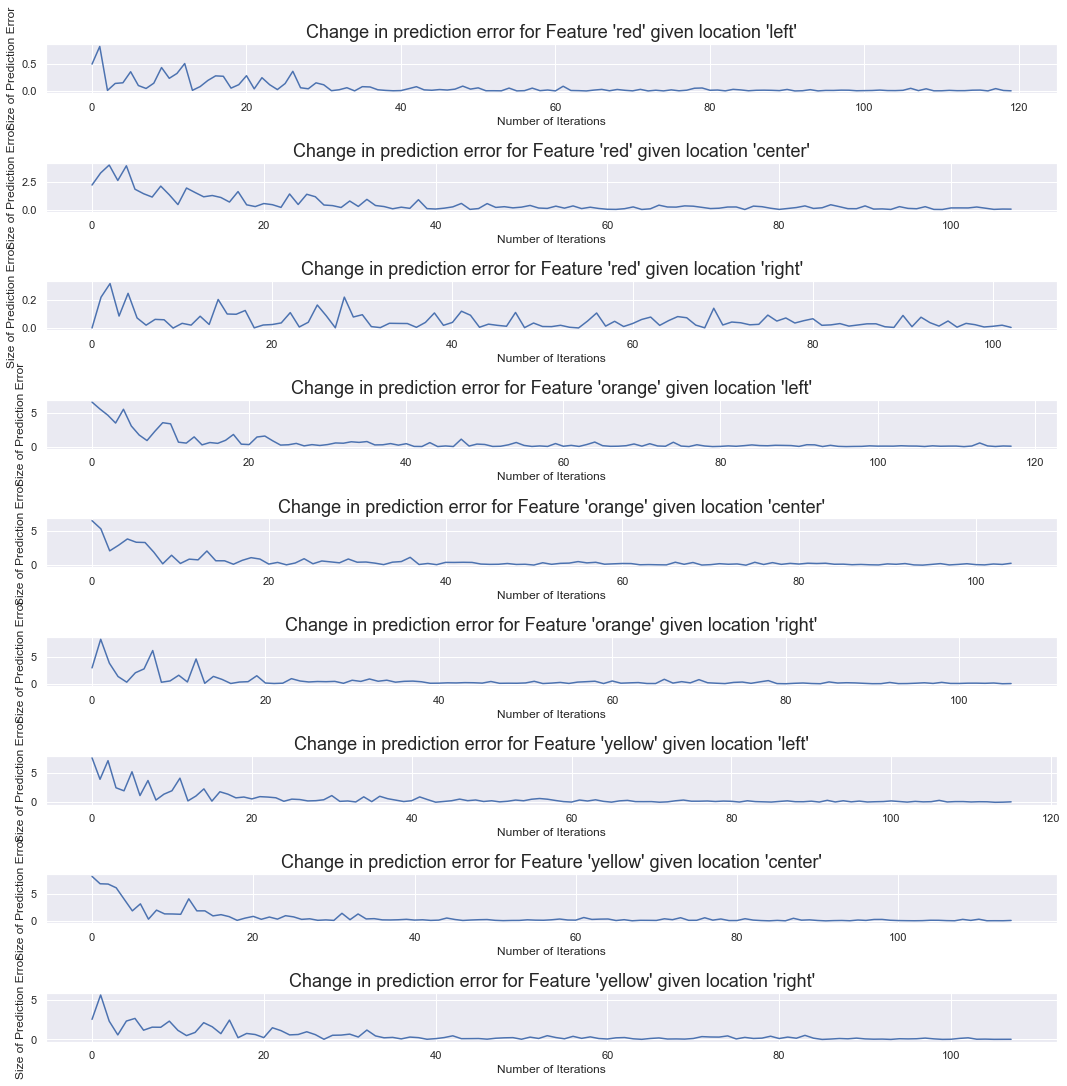

In [223]:
###Running the simulation###

#The environment is supposed to be deterministic but 
#due to the nature of Kullback Leibler divergence the probabilities cannot be zero.
#                             Left                                Middle                               Right
#psi_env = np.array([[[0.99997,0.00001,0.00001,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.99997,0.00001,0.00001,0.00001]],
#                    [[0.00001,0.00001,0.99997,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.00001,0.00001,0.99997,0.00001]],
#                    [[0.00001,0.99997,0.00001,0.00001],[0.00001,0.00001,0.00001,0.99997],[0.00001,0.99997,0.00001,0.00001]]])
psi_env = np.array([[[0.5,0.25,0.25],[0.00001,0.00001,0.99998],[0.5,0.25,0.25]],
                    [[0.00001,0.00001,0.99998],[0.00001,0.00001,0.99998],[0.00001,0.00001,0.99998]],
                    [[0.00001,0.99998,0.00001],[0.00001,0.00001,0.99998],[0.00001,0.99998,0.00001]]])
f_names = ["red", "orange", "yellow"]
o_names = ["circle", "square", "triangle"]
l_names = ["left", "center", "right"]
alpha_agent, pre_errors = trial(1000, len(o_names), len(f_names), len(l_names), psi_env) ##  added len(list) instead of hardcoding the length.


k=0
fig, ax = plt.subplots(len(f_names)*len(l_names), 1, figsize=(15,15)) ## added len(list) instead of hardcoding the length.
for i in range(len(f_names)):
    for j in range(len(l_names)):
        ax[k].plot(pre_errors[i][j])
        ax[k].set_title("Change in prediction error for Feature '{}' given location '{}'".format(f_names[i],l_names[j]), fontsize=18)    
        ax[k].set_xlabel("Number of Iterations")
        ax[k].set_ylabel("Size of Prediction Error")
        k+=1
fig.tight_layout() 
print(alpha_agent)

In [224]:
#Plotting the dirichlet function
#Code was taken from http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
#corners = np.array([[0, 0], [1, 0], [0,1],[1,1]])
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
def draw_pdf_contours(dist,title, nlevels=200, subdiv=8, **kwargs):
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels,cmap="plasma", **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.title(title)
    plt.show()
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     functools.reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * functools.reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])   

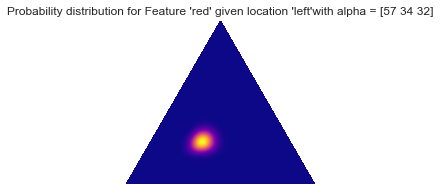

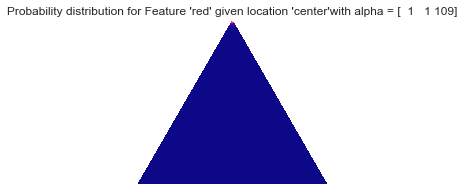

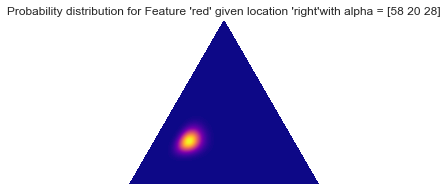

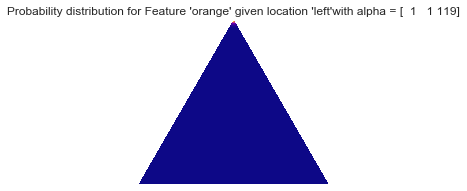

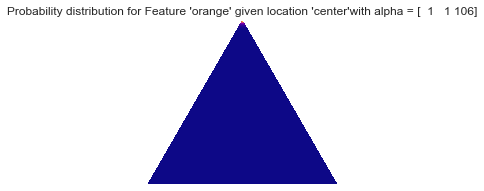

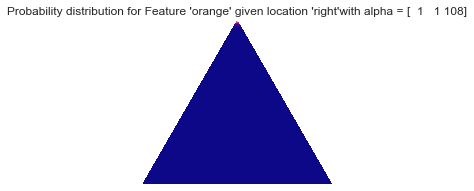

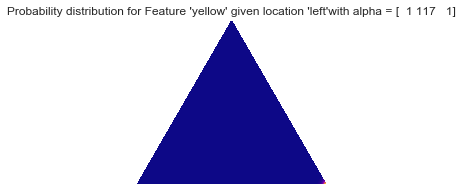

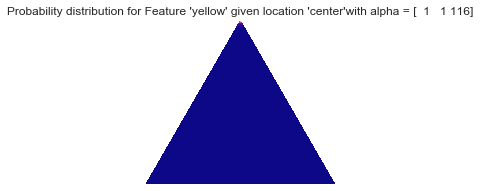

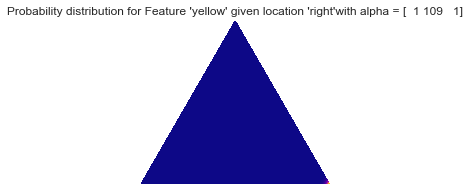

In [225]:
for i in range(len(f_names)):
    for j in range(len(l_names)):
        draw_pdf_contours(Dirichlet(alpha_agent[i][j]),
                          "Probability distribution for Feature '{}' given location '{}' with alpha = {}".format(f_names[i],l_names[j], alpha_agent[i][j]))


In [158]:
x = np.arange(0,1,0.1)
y = np.arange(0,1,0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
#z = [Dirichlet([5,3,2,4]).pdf() for x in xx for y in yy]
z2 = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

h = plt.contourf(x,y,z)
plt.show()

print(dirichlet.pdf(alpha=[200,1,2,1],x=[0.01,0.01, 0.08, 0.9]))
corners = np.array([[0,0],[0,1],[1,1],[1,0]])
midpoints = [(corners[i%4] + corners[(i+1) % 4]) / 2.0 for i in range(4)]
print(midpoints)
def xy24D(xy,tol=1.e-3):
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i])/0.5
         for i in range(4)]
    return s
print(xy24D([1,0]))


array([ 7, 13])